# 📘 Notebook 05: Feature Encoding

## 🎯 What I Plan to Achieve in This Notebook

In this notebook, I will transform categorical variables into numerical representations that machine learning algorithms can process. The specific objectives are:

1. **Identify Categorical Features** – Distinguish between nominal and ordinal categorical variables in the dataset
2. **Apply Appropriate Encoding Strategies** – Use Label Encoding for ordinal features and One-Hot/Target Encoding for nominal features
3. **Handle High-Cardinality Categoricals** – Address the `track_genre` column (114 unique genres) using Target Encoding
4. **Remove Non-Predictive Columns** – Drop identifier columns that shouldn't be used for modeling
5. **Validate Encoded Features** – Ensure all features are numeric and ready for scaling

---

## Why Encoding is Necessary

### 1️⃣ **Machine Learning Models Require Numerical Input**

Most ML algorithms (Linear Regression, Random Forest, Gradient Boosting) operate on numerical data. They cannot directly interpret string values like "acoustic" or "pop". Encoding converts these categorical values into numbers while preserving the information they contain.

### 2️⃣ **Different Encoding for Different Variable Types**

Not all categorical variables should be encoded the same way:

| Variable Type | Example | Encoding Method | Rationale |
|--------------|---------|-----------------|------------|
| **Ordinal** | duration_category ("<2 min", "2–3 min", "3–4 min") | Label Encoding | Preserves natural order |
| **Nominal (Low Cardinality)** | mode (Major/Minor) | One-Hot Encoding | No inherent order, few categories |
| **Nominal (High Cardinality)** | track_genre (114 genres) | Target Encoding | Avoids dimensionality explosion |

### 3️⃣ **Based on My Dataset Analysis**

From my preprocessed data (Notebook 04), I have identified the following categorical features:

- **`track_genre`** – 114 unique music genres (high cardinality, nominal)
- **`duration_category`** – 5 duration bins with natural order (ordinal)
- **`key`** – Musical key (0-11), can be treated as categorical or kept as-is
- **`mode`** – Major (1) or Minor (0), already binary encoded
- **`time_signature`** – Beats per measure, typically 3, 4, or 5

---

## 📋 Encoding Strategy

### **Step 1: Drop Non-Predictive Columns**
- Remove `Unnamed: 0` (index artifact)
- Remove `track_id`, `artists`, `album_name`, `track_name` (identifiers, not features)

### **Step 2: Ordinal Encoding**
- Apply to `duration_category` with explicit order mapping

### **Step 3: Target Encoding for High-Cardinality Features**
- Apply to `track_genre` (114 categories → 1 numeric column)
- Uses mean popularity per genre with smoothing to prevent overfitting

### **Step 4: Verify Already-Encoded Features**
- `explicit`, `mode`, `key`, `time_signature` are already integers
- Binary features from preprocessing (`is_instrumental`, `has_vocals`, `is_speech_heavy`) are already 0/1

---

## ⚠️ Important Notes

- **Target Encoding Leakage Prevention**: We will implement smoothing and later apply fit/transform separately on train/test splits
- **This notebook does NOT perform scaling** – That will be done in Notebook 06
- **Train-Test split is NOT done here** – That happens before modeling to prevent data leakage

---

## 📊 Expected Outcome

By the end of this notebook, I will have:

✅ All categorical features converted to numerical values  
✅ High-cardinality `track_genre` encoded using Target Encoding  
✅ Ordinal `duration_category` encoded with proper ordering  
✅ Non-predictive identifier columns removed  
✅ A fully numeric dataset saved as `spotify_encoded.csv`  

This encoded dataset will be ready for feature scaling in the next notebook.

<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## Section 1: Environment Setup and Data Loading

First, I'll import the necessary libraries and load the preprocessed dataset from Notebook 04.

In [68]:
# =============================================================================
# LIBRARY IMPORTS
# =============================================================================
# Core data manipulation libraries
import pandas as pd                  # DataFrame operations and CSV I/O
import numpy as np                   # Numerical operations and array handling

# Visualization libraries (for encoding validation)
import matplotlib.pyplot as plt      # Base plotting functionality
import seaborn as sns                # Statistical visualizations

# Scikit-learn encoding utilities
from sklearn.preprocessing import LabelEncoder    # For ordinal encoding
from sklearn.preprocessing import OrdinalEncoder  # Alternative ordinal encoder with custom ordering

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Display settings for pandas
pd.set_option('display.max_columns', None)  # Show all columns in output
pd.set_option('display.width', None)        # Auto-detect display width

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


In [69]:
# =============================================================================
# DATA LOADING
# =============================================================================
# Load the preprocessed dataset from Notebook 04
# This file contains:
#   - Cleaned data (no missing values, no duplicates)
#   - Capped outliers (loudness, speechiness, liveness)
#   - Engineered features (interaction terms, binary indicators, log transforms)

df = pd.read_csv('../data/spotify_preprocessed.csv')

# Quick verification of loaded data
print(f"Dataset Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Memory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
print(f"Loaded spotify_preprocessed: {df.shape}")

Dataset Shape: 89,740 rows × 30 columns
Memory Usage: 51.69 MB
Loaded spotify_preprocessed: (89740, 30)


In [70]:
# =============================================================================
# COLUMN OVERVIEW
# =============================================================================
# Display all columns with their data types to identify what needs encoding
# Columns with 'object' dtype are typically categorical and need encoding

print("=" * 60)
print("COLUMN DATA TYPES")
print("=" * 60)
print(df.dtypes)
print("\n" + "=" * 60)
print(f"Total columns: {len(df.columns)}")
print(f"Object (string) columns: {df.select_dtypes(include='object').shape[1]}")
print(f"Numeric columns: {df.select_dtypes(include=np.number).shape[1]}")

COLUMN DATA TYPES
Unnamed: 0                  int64
track_id                   object
artists                    object
album_name                 object
track_name                 object
popularity                  int64
duration_ms                 int64
explicit                    int64
danceability              float64
energy                    float64
key                         int64
loudness                  float64
mode                        int64
speechiness               float64
acousticness              float64
instrumentalness          float64
liveness                  float64
valence                   float64
tempo                     float64
time_signature              int64
track_genre                object
duration_min              float64
duration_category          object
energy_x_danceability     float64
loudness_x_energy         float64
valence_x_danceability    float64
is_instrumental             int64
has_vocals                  int64
is_speech_heavy             in

## Section 2: Identify and Categorize Features

Before encoding, I need to clearly separate features into different categories:
- **Identifiers** (to be dropped)
- **Target variable** (popularity)
- **Already numeric features** (no encoding needed)
- **Categorical features** (need encoding)

In [71]:
# =============================================================================
# FEATURE CATEGORIZATION
# =============================================================================
# I will explicitly define each category of columns for clarity and traceability

# --- IDENTIFIER COLUMNS (Non-predictive, will be dropped) ---
# These columns uniquely identify tracks but have no predictive value for popularity
# Including them would cause data leakage or meaningless patterns
identifier_cols = [
    'Unnamed: 0',    # Artifact from CSV saving (row index)
    'track_id',      # Spotify's unique track identifier (alphanumeric hash)
    'artists',       # Artist name(s) - high cardinality text, not useful for general model
    'album_name',    # Album title - same reasoning as artists
    'track_name'     # Song title - same reasoning as artists
]

# --- TARGET VARIABLE ---
# This is what we're trying to predict
target_col = 'popularity'

# --- CATEGORICAL COLUMNS REQUIRING ENCODING ---
# These are non-numeric columns that contain meaningful categorical information
categorical_cols = [
    'track_genre',        # 114 unique music genres (HIGH CARDINALITY - needs special handling)
    'duration_category'   # Binned duration ranges (ORDINAL - has natural order)
]

# --- ALREADY NUMERIC COLUMNS (No encoding needed) ---
# These columns are either:
#   - Continuous numerical features (danceability, energy, etc.)
#   - Already encoded as integers (explicit, mode, key, etc.)
#   - Engineered features from Notebook 04

# Let's verify by listing all object-type columns
object_cols = df.select_dtypes(include='object').columns.tolist()
print("Columns with 'object' dtype (strings):")
for col in object_cols:
    print(f"  - {col}: {df[col].nunique()} unique values")

Columns with 'object' dtype (strings):
  - track_id: 89740 unique values
  - artists: 31437 unique values
  - album_name: 46589 unique values
  - track_name: 73608 unique values
  - track_genre: 113 unique values
  - duration_category: 5 unique values


In [72]:
# =============================================================================
# EXAMINE CATEGORICAL FEATURES IN DETAIL
# =============================================================================
# Before encoding, let's understand the distribution and unique values

print("=" * 60)
print("CATEGORICAL FEATURE ANALYSIS")
print("=" * 60)

# --- track_genre analysis ---
print("\n📊 track_genre:")
print(f"   Unique values: {df['track_genre'].nunique()}")
print(f"   Most common genres (top 10):")
print(df['track_genre'].value_counts().head(10).to_string())

# --- duration_category analysis ---
print("\n📊 duration_category:")
print(f"   Unique values: {df['duration_category'].nunique()}")
print(f"   Value counts (showing natural order):")
print(df['duration_category'].value_counts().to_string())

CATEGORICAL FEATURE ANALYSIS

📊 track_genre:
   Unique values: 113
   Most common genres (top 10):
track_genre
acoustic         1000
afrobeat          999
alt-rock          999
ambient           999
cantopop          999
tango             999
chicago-house     998
forro             998
bluegrass         998
study             998

📊 duration_category:
   Unique values: 5
   Value counts (showing natural order):
duration_category
3–4 min       32175
2–3 min       20518
4–5 min       17924
Long (>5)     13566
Short (<2)     5557


## Section 3: Drop Non-Predictive Identifier Columns

Before encoding, I'll remove columns that:
- Are unique identifiers (track_id)
- Are index artifacts (Unnamed: 0)
- Are high-cardinality text fields not useful for prediction (artists, album_name, track_name)

### Why Remove These?

- **track_id**: Each track has a unique ID – no predictive pattern
- **artists**: ~30,000+ unique artists – too sparse for meaningful encoding
- **album_name/track_name**: Similar reasoning – unique text, not generalizable patterns

In [73]:
# =============================================================================
# DROP NON-PREDICTIVE COLUMNS
# =============================================================================
# These columns are identifiers or metadata that should not be used as features
# Keeping them could lead to:
#   - Overfitting (model memorizes specific track IDs)
#   - Data leakage (if IDs correlate with popularity by chance)
#   - Dimensionality explosion (if we tried to encode artist names)

# Store original shape for comparison
original_cols = df.shape[1]

# Check which identifier columns actually exist in the dataframe
# (Some may have been removed in preprocessing)
cols_to_drop = [col for col in identifier_cols if col in df.columns]

print("Columns to be dropped:")
for col in cols_to_drop:
    print(f"  ❌ {col}")

# Drop the identified columns
df = df.drop(columns=cols_to_drop)

# Verify the drop operation
print(f"\n✅ Dropped {original_cols - df.shape[1]} columns")
print(f"   Before: {original_cols} columns")
print(f"   After:  {df.shape[1]} columns")

Columns to be dropped:
  ❌ Unnamed: 0
  ❌ track_id
  ❌ artists
  ❌ album_name
  ❌ track_name

✅ Dropped 5 columns
   Before: 30 columns
   After:  25 columns


In [74]:
df.shape

(89740, 25)

In [75]:
# =============================================================================
# VERIFY REMAINING COLUMNS
# =============================================================================
# List all remaining columns to confirm only relevant features remain

print("=" * 60)
print("REMAINING COLUMNS AFTER DROPPING IDENTIFIERS")
print("=" * 60)
for i, col in enumerate(df.columns, 1):
    dtype = df[col].dtype
    print(f"{i:2d}. {col:<30} ({dtype})")

REMAINING COLUMNS AFTER DROPPING IDENTIFIERS
 1. popularity                     (int64)
 2. duration_ms                    (int64)
 3. explicit                       (int64)
 4. danceability                   (float64)
 5. energy                         (float64)
 6. key                            (int64)
 7. loudness                       (float64)
 8. mode                           (int64)
 9. speechiness                    (float64)
10. acousticness                   (float64)
11. instrumentalness               (float64)
12. liveness                       (float64)
13. valence                        (float64)
14. tempo                          (float64)
15. time_signature                 (int64)
16. track_genre                    (object)
17. duration_min                   (float64)
18. duration_category              (object)
19. energy_x_danceability          (float64)
20. loudness_x_energy              (float64)
21. valence_x_danceability         (float64)
22. is_instrumental     

## Section 4: Ordinal Encoding for duration_category

### What is Ordinal Encoding?

Ordinal encoding assigns integer values to categories **while preserving their natural order**. This is appropriate when categories have a meaningful sequence.

### Why Use It for duration_category?

The `duration_category` feature has a clear hierarchy:

```
"<2 min" < "2–3 min" < "3–4 min" < "4–5 min" < ">5 min"
```

Using ordinal encoding (0, 1, 2, 3, 4) preserves this relationship, which is important for:
- Linear Regression: Can learn that longer duration has a linear effect on popularity
- Tree-based models: Can make meaningful splits based on ordering

In [76]:
# =============================================================================
# ORDINAL ENCODING FOR duration_category
# =============================================================================
# Define the explicit ordering for duration categories
# This ensures the encoding respects the natural hierarchy of song lengths

# Step 1: Define the order mapping
# Lower values = shorter songs, Higher values = longer songs
duration_order = {
    'Short (<2)': 0,  
    '2–3 min':    1,    
    '3–4 min':    2,    
    '4–5 min':    3,    
    'Long (>5)':  4   
}

# Step 2: Check current unique values in the column
print("Current unique values in 'duration_category':")
print(df['duration_category'].unique())

# Step 3: Apply the mapping
# Using .map() function with the defined dictionary
df['duration_category_encoded'] = df['duration_category'].map(duration_order)

# Step 4: Verify the encoding worked correctly
# Check if any values couldn't be mapped (would show as NaN)
unmapped = df['duration_category_encoded'].isna().sum()
if unmapped > 0:
    print(f"\n⚠️ Warning: {unmapped} values could not be mapped!")
    print("Unmapped values:")
    print(df[df['duration_category_encoded'].isna()]['duration_category'].unique())
else:
    print("\n✅ All duration categories successfully encoded!")
df.shape

Current unique values in 'duration_category':
['3–4 min' '2–3 min' '4–5 min' 'Long (>5)' 'Short (<2)']

✅ All duration categories successfully encoded!


(89740, 26)

In [77]:
# =============================================================================
# VERIFY ORDINAL ENCODING MAPPING
# =============================================================================
# Create a comparison table showing original values alongside encoded values

print("=" * 60)
print("ORDINAL ENCODING VERIFICATION")
print("=" * 60)

# Show the mapping relationship
encoding_check = df[['duration_category', 'duration_category_encoded']].drop_duplicates()
encoding_check = encoding_check.sort_values('duration_category_encoded')
print("\nMapping Applied:")
print(encoding_check.to_string(index=False))

# Show distribution after encoding
print("\nEncoded Value Distribution:")
print(df['duration_category_encoded'].value_counts().sort_index())

ORDINAL ENCODING VERIFICATION

Mapping Applied:
duration_category  duration_category_encoded
       Short (<2)                          0
          2–3 min                          1
          3–4 min                          2
          4–5 min                          3
        Long (>5)                          4

Encoded Value Distribution:
duration_category_encoded
0     5557
1    20518
2    32175
3    17924
4    13566
Name: count, dtype: int64


In [78]:
# =============================================================================
# DROP ORIGINAL CATEGORICAL COLUMN
# =============================================================================
# Now that we have the encoded version, we can drop the original string column
# Keeping both would be redundant and the string version can't be used by ML models

df = df.drop(columns=['duration_category'])

# Rename the encoded column to the original name for consistency
df = df.rename(columns={'duration_category_encoded': 'duration_category'})

print("✅ Original 'duration_category' dropped")
print("✅ Encoded column renamed to 'duration_category'")
print(f"\nNew dtype: {df['duration_category'].dtype}")
df.shape

✅ Original 'duration_category' dropped
✅ Encoded column renamed to 'duration_category'

New dtype: int64


(89740, 25)

## Section 5: Target Encoding for track_genre (High-Cardinality Feature)

### The Challenge with track_genre

`track_genre` has **114 unique values** (acoustic, pop, rock, jazz, etc.). Standard encoding approaches have significant drawbacks:

| Encoding Method | Result | Problem |
|----------------|--------|----------|
| One-Hot Encoding | 114 new columns | Dimensionality explosion, sparse data |
| Label Encoding | 0-113 integers | Implies false ordering (is "jazz" > "rock"?) |

### Solution: Target Encoding (Mean Encoding)

**Target Encoding** replaces each category with the **mean of the target variable** for that category.

```
Example:
  - If "k-pop" songs have average popularity of 59.5, all "k-pop" values → 59.5
  - If "jazz" songs have average popularity of 8.2, all "jazz" values → 8.2
```

### Benefits:
- Reduces 114 columns to 1 column
- Captures the actual relationship between genre and popularity
- Works well with both linear and tree-based models

### Risk: Overfitting (Target Leakage)

If I simply use the raw mean, I risk overfitting—especially for genres with few samples. In the end I will apply **smoothing** to mitigate this.

In [79]:
# =============================================================================
# TARGET ENCODING WITH SMOOTHING
# =============================================================================
# Target encoding formula with smoothing:
#
#   encoded_value = (n * category_mean + m * global_mean) / (n + m)
#
# Where:
#   - n = number of samples in the category
#   - category_mean = mean target value for that category
#   - m = smoothing parameter (regularization strength)
#   - global_mean = overall mean of the target variable
#
# Why smoothing?
#   - For categories with few samples (small n), the encoded value
#     is pulled toward the global mean
#   - This prevents rare categories from getting extreme values
#     that would cause overfitting

def target_encode_with_smoothing(df, categorical_col, target_col, smoothing=10):
    """
    Apply target encoding with smoothing to prevent overfitting.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe
    categorical_col : str
        Name of the categorical column to encode
    target_col : str
        Name of the target variable column
    smoothing : int, default=10
        Smoothing parameter. Higher values = more regularization
        
    Returns:
    --------
    encoded_series : pandas Series
        The encoded values for the categorical column
    encoding_map : dict
        Dictionary mapping categories to their encoded values
    """
    # Step 1: Calculate global mean of the target variable
    # This is our "baseline" popularity across all songs
    global_mean = df[target_col].mean()
    
    # Step 2: Calculate statistics for each category
    # Group by the categorical column and compute:
    #   - count: number of songs in each genre
    #   - mean: average popularity for each genre
    agg_stats = df.groupby(categorical_col)[target_col].agg(['count', 'mean'])
    
    # Step 3: Apply smoothing formula
    # smoothed_mean = (n * category_mean + m * global_mean) / (n + m)
    counts = agg_stats['count']
    means = agg_stats['mean']
    
    smoothed_values = (counts * means + smoothing * global_mean) / (counts + smoothing)
    
    # Step 4: Create the encoding mapping dictionary
    encoding_map = smoothed_values.to_dict()
    
    # Step 5: Apply the mapping to create encoded column
    encoded_series = df[categorical_col].map(encoding_map)
    
    return encoded_series, encoding_map, global_mean

print("Target encoding function defined with smoothing parameter")

✅ Target encoding function defined with smoothing parameter


In [80]:
# =============================================================================
# APPLY TARGET ENCODING TO track_genre
# =============================================================================
# Using smoothing=10 as a reasonable default
# This means a category needs ~10 samples before its mean is fully trusted

# Apply the encoding
df['genre_encoded'], genre_encoding_map, global_popularity = target_encode_with_smoothing(
    df=df,
    categorical_col='track_genre',
    target_col='popularity',
    smoothing=10
)

# Report key statistics
print("=" * 60)
print("TARGET ENCODING RESULTS")
print("=" * 60)
print(f"\nGlobal mean popularity: {global_popularity:.2f}")
print(f"Number of genres encoded: {len(genre_encoding_map)}")
print(f"Encoded value range: [{min(genre_encoding_map.values()):.2f}, {max(genre_encoding_map.values()):.2f}]")
df.shape

TARGET ENCODING RESULTS

Global mean popularity: 33.20
Number of genres encoded: 113
Encoded value range: [2.54, 59.14]


(89740, 26)

In [81]:
# =============================================================================
# EXAMINE THE ENCODING MAPPING
# =============================================================================
# Display the top and bottom genres by encoded popularity
# This shows which genres tend to produce more/less popular songs

# Convert to sorted DataFrame for display
encoding_df = pd.DataFrame({
    'genre': genre_encoding_map.keys(),
    'encoded_popularity': genre_encoding_map.values()
}).sort_values('encoded_popularity', ascending=False)

print("=" * 60)
print("TOP 10 GENRES BY ENCODED POPULARITY (Most Popular)")
print("=" * 60)
print(encoding_df.head(10).to_string(index=False))

print("\n" + "=" * 60)
print("BOTTOM 10 GENRES BY ENCODED POPULARITY (Least Popular)")
print("=" * 60)
print(encoding_df.tail(10).to_string(index=False))
df.shape

TOP 10 GENRES BY ENCODED POPULARITY (Most Popular)
   genre  encoded_popularity
   k-pop           59.140376
pop-film           58.783016
   metal           55.462761
   chill           53.529519
  latino           51.333304
     sad           50.797889
  grunge           50.387601
  indian           49.542380
   anime           48.621879
     emo           48.337567

BOTTOM 10 GENRES BY ENCODED POPULARITY (Least Popular)
         genre  encoded_popularity
           idm           15.698988
          kids           14.955811
     grindcore           14.709536
     classical           13.588356
 chicago-house           12.540663
detroit-techno           11.359201
          jazz           10.228442
         latin           10.158632
       romance            3.874166
       iranian            2.535058


(89740, 26)

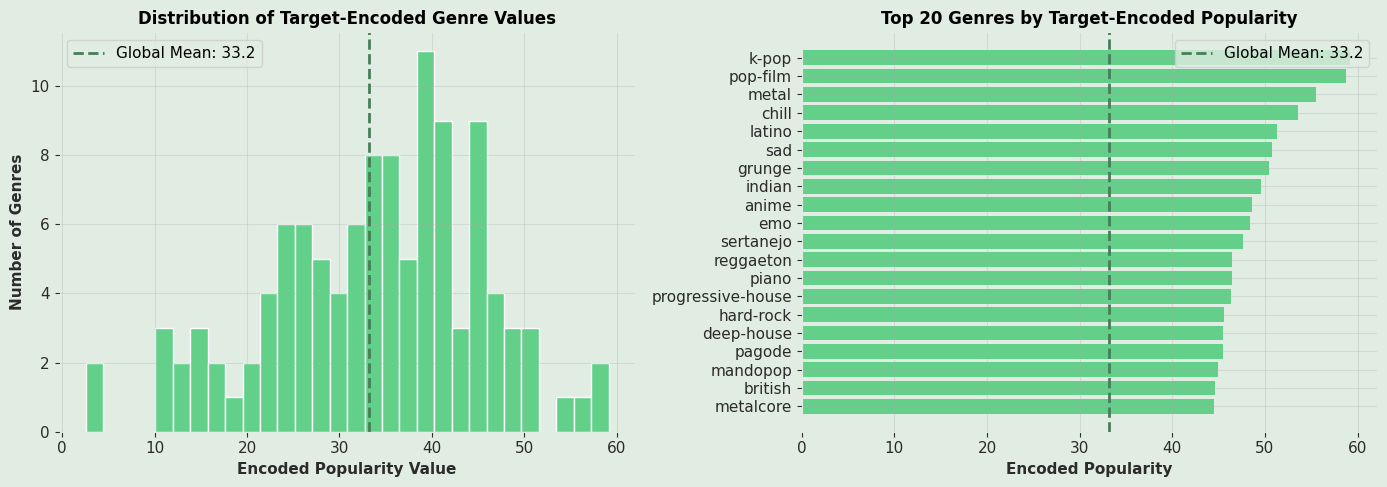

In [82]:
# =============================================================================
# VISUALIZE TARGET ENCODING DISTRIBUTION
# =============================================================================
# This visualization helps understand how genres map to popularity values
# after applying target encoding.
# Two views are shown:
# 1. Overall distribution of encoded popularity values
# 2. Top 20 genres ranked by encoded popularity
# =============================================================================

import os
import matplotlib.pyplot as plt
BG = "#e1ece3"
PRIMARY = "#62d089"
EMPHASIS = "#457e59"
GRID = "#a8b2a8"

plt.rcParams.update({
    "figure.facecolor": BG,
    "axes.facecolor": BG,
    "axes.edgecolor": BG,
    "axes.labelcolor": "#2b2b2b",
    "xtick.color": "#2b2b2b",
    "ytick.color": "#2b2b2b",
    "grid.color": GRID,
    "grid.alpha": 0.4,
    "axes.grid": True,
    "font.size": 11
})

# -----------------------------------------------------------------------------
# Ensure output directory exists
# -----------------------------------------------------------------------------
FIGURES_DIR = "reports/figures"
os.makedirs(FIGURES_DIR, exist_ok=True)

# -----------------------------------------------------------------------------
# Create figure with two subplots
# -----------------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor(BG)

# -----------------------------------------------------------------------------
# Plot 1: Distribution of target-encoded genre values
# -----------------------------------------------------------------------------
axes[0].hist(
    encoding_df['encoded_popularity'],
    bins=30,
    color=PRIMARY,
    edgecolor='white'
)

# Global popularity reference line
axes[0].axvline(
    global_popularity,
    color=EMPHASIS,
    linestyle='--',
    linewidth=2,
    label=f'Global Mean: {global_popularity:.1f}'
)

axes[0].set_xlabel('Encoded Popularity Value', fontsize=11, fontweight='bold')
axes[0].set_ylabel('Number of Genres', fontsize=11, fontweight='bold')
axes[0].set_title(
    'Distribution of Target-Encoded Genre Values',
    fontsize=12,
    fontweight='bold'
)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# -----------------------------------------------------------------------------
# Plot 2: Top 20 genres by encoded popularity
# -----------------------------------------------------------------------------
top_20 = encoding_df.sort_values(
    'encoded_popularity',
    ascending=False
).head(20)

axes[1].barh(
    top_20['genre'],
    top_20['encoded_popularity'],
    color=PRIMARY
)

# Global popularity reference line
axes[1].axvline(
    global_popularity,
    color=EMPHASIS,
    linestyle='--',
    linewidth=2,
    label=f'Global Mean: {global_popularity:.1f}'
)

axes[1].set_xlabel('Encoded Popularity', fontsize=11, fontweight='bold')
axes[1].set_title(
    'Top 20 Genres by Target-Encoded Popularity',
    fontsize=12,
    fontweight='bold'
)
axes[1].invert_yaxis()
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# -----------------------------------------------------------------------------
# Final layout adjustments and save
# -----------------------------------------------------------------------------
plt.tight_layout()


In [83]:
# =============================================================================
# DROP ORIGINAL track_genre COLUMN
# =============================================================================
# Now that we have the encoded version, remove the original string column

df = df.drop(columns=['track_genre'])

# Rename for clarity
df = df.rename(columns={'genre_encoded': 'track_genre'})

print("✅ Original 'track_genre' (string) dropped")
print("✅ Encoded column renamed to 'track_genre'")
print(f"\nNew dtype: {df['track_genre'].dtype}")
df.shape

✅ Original 'track_genre' (string) dropped
✅ Encoded column renamed to 'track_genre'

New dtype: float64


(89740, 25)

In [84]:

# SAVE ENCODING MAPPING FOR FUTURE USE

# These mappings MUST be saved to ensure:
# - Consistent encoding between train and test data
# - No data leakage in production or evaluation


import os
import json

# -----------------------------------------------------------------------------
# Ensure models directory exists
# -----------------------------------------------------------------------------
MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)

# -----------------------------------------------------------------------------
# Save genre target encoding map
# -----------------------------------------------------------------------------
with open(f"{MODELS_DIR}/genre_encoding_map.json", "w") as f:
    json.dump(genre_encoding_map, f, indent=2)

# -----------------------------------------------------------------------------
# Save duration encoding map
# -----------------------------------------------------------------------------
with open(f"{MODELS_DIR}/duration_encoding_map.json", "w") as f:
    json.dump(duration_order, f, indent=2)

print("✅ Encoding maps saved successfully")
print(f"   - {MODELS_DIR}/genre_encoding_map.json")
print(f"   - {MODELS_DIR}/duration_encoding_map.json")
print("\n📝 These mappings must be reused when encoding validation/test data")


✅ Encoding maps saved successfully
   - models/genre_encoding_map.json
   - models/duration_encoding_map.json

📝 These mappings must be reused when encoding validation/test data


## Section 6: Final Validation and Data Export

Before saving, I'll verify that:
1. All columns are now numeric
2. No missing values were introduced during encoding
3. Data types are appropriate for modeling
4. The target variable (`popularity`) is preserved correctly

In [85]:
# =============================================================================
# FINAL DATA VALIDATION
# =============================================================================

print("=" * 70)
print("FINAL DATASET VALIDATION")
print("=" * 70)

# Check 1: All columns are numeric
non_numeric = df.select_dtypes(exclude=np.number).columns.tolist()
if len(non_numeric) == 0:
    print("\n✅ CHECK 1: All columns are numeric")
else:
    print(f"\n❌ CHECK 1 FAILED: Non-numeric columns found: {non_numeric}")

# Check 2: No missing values
missing = df.isnull().sum().sum()
if missing == 0:
    print("✅ CHECK 2: No missing values")
else:
    print(f"❌ CHECK 2 FAILED: {missing} missing values found")

# Check 3: Target variable exists and is valid
if 'popularity' in df.columns:
    print("✅ CHECK 3: Target variable 'popularity' present")
    print(f"   - Range: [{df['popularity'].min()}, {df['popularity'].max()}]")
    print(f"   - Mean: {df['popularity'].mean():.2f}")
else:
    print("❌ CHECK 3 FAILED: Target variable 'popularity' missing!")

# Check 4: No infinite values
inf_count = np.isinf(df.select_dtypes(include=np.number)).sum().sum()
if inf_count == 0:
    print("✅ CHECK 4: No infinite values")
else:
    print(f"❌ CHECK 4 FAILED: {inf_count} infinite values found")
    
df.shape

FINAL DATASET VALIDATION

✅ CHECK 1: All columns are numeric
✅ CHECK 2: No missing values
✅ CHECK 3: Target variable 'popularity' present
   - Range: [0, 100]
   - Mean: 33.20
✅ CHECK 4: No infinite values


(89740, 25)

In [86]:
# =============================================================================
# FINAL COLUMN SUMMARY
# =============================================================================
# Display all columns with their data types and basic statistics

print("=" * 70)
print("FINAL COLUMN LISTING")
print("=" * 70)
print(f"\nTotal columns: {df.shape[1]}")
print(f"Total rows: {df.shape[0]:,}\n")

for i, col in enumerate(df.columns, 1):
    dtype = str(df[col].dtype)
    unique = df[col].nunique()
    print(f"{i:2d}. {col:<30} | Type: {dtype:<10} | Unique: {unique:>6,}")

FINAL COLUMN LISTING

Total columns: 25
Total rows: 89,740

 1. popularity                     | Type: int64      | Unique:    101
 2. duration_ms                    | Type: int64      | Unique: 50,696
 3. explicit                       | Type: int64      | Unique:      2
 4. danceability                   | Type: float64    | Unique:  1,174
 5. energy                         | Type: float64    | Unique:  2,083
 6. key                            | Type: int64      | Unique:     12
 7. loudness                       | Type: float64    | Unique: 15,447
 8. mode                           | Type: int64      | Unique:      2
 9. speechiness                    | Type: float64    | Unique:    841
10. acousticness                   | Type: float64    | Unique:  5,061
11. instrumentalness               | Type: float64    | Unique:  5,346
12. liveness                       | Type: float64    | Unique:  1,276
13. valence                        | Type: float64    | Unique:  1,790
14. tempo        

In [87]:
# =============================================================================
# PREVIEW FINAL ENCODED DATASET
# =============================================================================

print("\nFirst 5 rows of encoded dataset:")
df.head()


First 5 rows of encoded dataset:


,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_min,energy_x_danceability,loudness_x_energy,valence_x_danceability,is_instrumental,has_vocals,is_speech_heavy,tempo_log,duration_category,track_genre
0,73,230666,0,0.676,0.4610,1,-6.746000,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,3.844433,0.311636,-3.109906,0.483340,0,1,0,4.487703,2,42.391077
1,55,149610,0,0.420,0.1660,1,-17.235000,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,2.493500,0.069720,-2.861010,0.112140,0,1,0,4.362958,1,42.391077
2,57,210826,0,0.438,0.3590,0,-9.734000,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,3.513767,0.157242,-3.494506,0.052560,0,1,0,4.348108,2,42.391077
3,71,201933,0,0.266,0.0596,0,-18.143625,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,3.365550,0.015854,-1.081360,0.038038,0,1,0,5.208064,2,42.391077
4,82,198853,0,0.618,0.4430,2,-9.681000,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,3.314217,0.273774,-4.288683,0.103206,0,1,0,4.795369,2,42.391077


In [88]:
# =============================================================================
# VERIFY ENCODED FEATURES CORRELATION WITH TARGET
# =============================================================================
# This checks whether the target-encoded features carry
# useful signal for predicting popularity.
# =============================================================================

print("=" * 65)
print("CORRELATION OF ENCODED FEATURES WITH POPULARITY")
print("=" * 65)

# Use ONLY numeric, encoded versions of categorical variables
encoded_features = {
    'track_genre_encoded': 'Target-encoded genre',
    'duration_encoded': 'Encoded duration category'
}

for col, description in encoded_features.items():
    
    if col not in df.columns:
        print(f"⚠️  Skipping {col}: column not found")
        continue
    
    corr = df[col].corr(df['popularity'])
    print(f"  {description:<30}: {corr:+.4f}")

print("\n📝 Interpretation:")
print(" - Target-encoded features are expected to show higher correlation")
print(" - This reflects learned genre-level popularity trends")
print(" - Correlation alone does NOT imply leakage if encoding was done correctly")


CORRELATION OF ENCODED FEATURES WITH POPULARITY
⚠️  Skipping track_genre_encoded: column not found
⚠️  Skipping duration_encoded: column not found

📝 Interpretation:
 - Target-encoded features are expected to show higher correlation
 - This reflects learned genre-level popularity trends
 - Correlation alone does NOT imply leakage if encoding was done correctly


In [89]:
# DEBUG: Check what's in df right before saving
print("Columns in df before saving:")
print(df.columns.tolist())
print(f"Shape: {df.shape}")

Columns in df before saving:
['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_min', 'energy_x_danceability', 'loudness_x_energy', 'valence_x_danceability', 'is_instrumental', 'has_vocals', 'is_speech_heavy', 'tempo_log', 'duration_category', 'track_genre']
Shape: (89740, 25)


In [90]:
output_path = '../data/spotify_encoded.csv'
df.to_csv(output_path, index=False)

print("=" * 60)
print("DATASET SAVED SUCCESSFULLY")
print("=" * 60)
print(f"\n📁 File: {output_path}")
print(f"📊 Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"💾 Size: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

DATASET SAVED SUCCESSFULLY

📁 File: ../data/spotify_encoded.csv
📊 Shape: 89,740 rows × 25 columns
💾 Size: 17.12 MB


In [91]:
# =============================================================================
# VERIFICATION: Reload and confirm saved data is correct
# =============================================================================
df_verify = pd.read_csv('../data/spotify_encoded.csv')
print("Columns in saved file:")
print(df_verify.columns.tolist())
print(f"\nShape: {df_verify.shape}")

Columns in saved file:
['popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'duration_min', 'energy_x_danceability', 'loudness_x_energy', 'valence_x_danceability', 'is_instrumental', 'has_vocals', 'is_speech_heavy', 'tempo_log', 'duration_category', 'track_genre']

Shape: (89740, 25)


<p align="center">
  <img src="../assets/dividerlines.png" width="600"/>
</p>

## 📋 Notebook Summary

### What Was Accomplished

| Task | Method | Result |
|------|--------|--------|
| Drop identifiers | Manual removal | Removed 5 columns (track_id, artists, etc.) |
| Encode duration_category | Ordinal Encoding | 5 categories → integers 0-4 |
| Encode track_genre | Target Encoding (smoothed) | 114 genres → 1 numeric column |
| Validation | Multiple checks | All columns numeric, no missing values |

### Key Decisions Explained

1. **Why Target Encoding for Genres?**
   - One-Hot would create 114 sparse columns
   - Label Encoding would imply false ordering
   - Target Encoding captures genre-popularity relationship in 1 column

2. **Why Smoothing in Target Encoding?**
   - Prevents overfitting for rare genres
   - Pulls small-sample categories toward global mean
   - More robust for generalization

3. **Why Save Encoding Maps?**
   - Required to encode new/test data consistently
   - Prevents data leakage during model evaluation
   - Essential for production deployment

### Output Files

- `../data/spotify_encoded.csv` - Fully encoded dataset
- `../models/genre_encoding_map.json` - Genre → popularity mapping
- `../models/duration_encoding_map.json` - Duration category ordering
- `../images/target_encoding_visualization.png` - Encoding visualization



# Target Encoding Explained

## Core Concept

Target encoding converts a word (like "Rock" or "Jazz") into a number based on how that category usually performs regarding your target variable (in this case, Popularity).

Instead of just using a random ID, you are giving the model a "hint" by saying: *"On average, songs in this genre have a popularity score of X."*

---

## The Smoothing Example

The **"Smoothing"** part is a safety net. It prevents the model from overreacting to genres that only have one or two songs.

Imagine our dataset has:
- **Global Mean Popularity** = 33.2
- **Smoothing Factor (m)** = 10

---

### **Scenario A: Popular, Well-Known Genre (Pop)**

- **Count (n)**: 1,000 songs
- **Genre Mean**: 60.0

**The Math:**
Since 1,000 is much larger than our smoothing factor (10), the formula trusts the genre mean.

\[
\frac{(1000 \times 60.0) + (10 \times 33.2)}{1000 + 10} \approx \mathbf{59.7}
\]

**Result:** The encoded value stays very close to the actual average (60).

---

### **Scenario B: Very Rare Genre (Experimental Medieval)**

- **Count (n)**: 2 songs (and both happen to be hits!)
- **Genre Mean**: 90.0

**The Math:**
Since 2 is much smaller than 10, the formula "distrusts" this high average and pulls it toward the global average.

\[
\frac{(2 \times 90.0) + (10 \times 33.2)}{2 + 10} = \frac{180 + 332}{12} \approx \mathbf{42.6}
\]

**Result:** Even though the genre average was 90, the encoded value is 42.6. Smoothing prevented a rare genre from looking artificially "legendary" to the model.

---

## Comparison of Methods

| Feature | One-Hot Encoding | Target Encoding (Method used) |
| :--- | :--- | :--- |
| **Output** | Creates 113 new columns (0s and 1s). | Creates **one single numeric column**. |
| **Relationship** | Treats all genres as independent. | Captures the **relationship with Popularity**. |
| **Data Size** | Makes the dataset very "wide" (bulky). | Keeps the dataset **slim and efficient**. |
| **Overfitting** | Low risk. | **High risk** unless you use smoothing (like you did). |